In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport make_index

In [16]:
%aimport utils

In [4]:
import satpy

In [5]:
import pyresample

In [20]:
import xarray as xr

In [6]:
import pandas as pd

In [7]:
import cartopy.crs as ccrs

In [8]:
from satpy.readers.utils import bbox, get_geostationary_angle_extent

In [263]:
f = 'l1b/g16/20200925T1800/01/OR_ABI-L1b-RadF-M6C01_G16_s20202691800201_e20202691809509_c20202691809570.nc'

In [264]:
area = make_index.get_area([f])

No filenames found for reader: goes-imager_nc
No filenames found for reader: viirs_compact
No filenames found for reader: seviri_l1b_nc
No filenames found for reader: mtsat2-imager_hrit
No filenames found for reader: amsr2_l1b
No filenames found for reader: nwcsaf-msg2013-hdf5
No filenames found for reader: sar-c_safe


In [265]:
scene = satpy.Scene([f],reader='abi_l1b')

In [266]:
scene.load(['C01'])

/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [267]:
c14 = scene['C01']

In [204]:
pc = utils.get_grid(.1)

In [268]:
ds = xr.open_dataset('satzen_cache/g16_satzen.nc')
satzen = ds.satzen.load()
ds.close()
del ds

In [40]:
r_footprint = 1e3
r_sample = 2e3
max_satzen = np.rad2deg(np.arccos(r_footprint / r_sample))
max_satzen

60.00000000000001

In [194]:
satzen_mask = ((satzen > max_satzen) & (satzen.notnull())).values

In [195]:
mask_idx = satzen_mask.ravel().nonzero()[0].astype(np.uint64)

In [209]:
%%time
grid_idx, sat_idx = make_index.get_index(area, pc, satzen.values, max_satzen, radius=r_sample)

CPU times: user 5.59 s, sys: 17.5 s, total: 23.1 s
Wall time: 58.5 s


In [210]:
%%time
grid_idx2, sat_idx2 = make_index.get_nn_index(area, pc, radius=10e3, nprocs=1)

CPU times: user 40.4 s, sys: 4.34 s, total: 44.7 s
Wall time: 16.2 s


In [269]:
satzen = satzen.interp(y=np.linspace(0,satzen.shape[0], area.shape[0]),
    x=np.linspace(0,satzen.shape[1], area.shape[1]))

In [240]:
grid = np.full(pc.shape, np.nan, dtype=np.float32)

In [241]:
# First, fill with the low quality nearest neighbor
grid.ravel()[grid_idx2] = c14.values.ravel()[sat_idx2]
grid1 = grid.copy()

(850.0, 750.0)

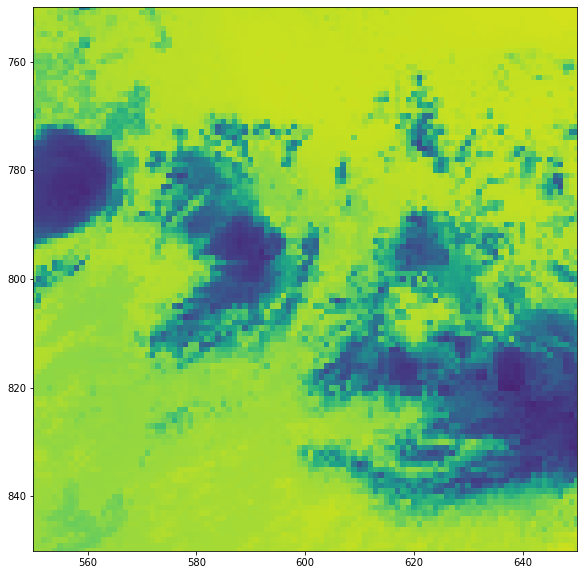

In [256]:
figure(figsize=(20,10))
imshow(grid1, vmin=200, vmax=300)
xlim([550,650])
ylim([850,750])

In [243]:
s = pd.Series(c14.values.ravel()[sat_idx], index=grid_idx)
s = s.groupby(s.index).mean()

In [244]:
grid.ravel()[s.index] = s.values

(850.0, 750.0)

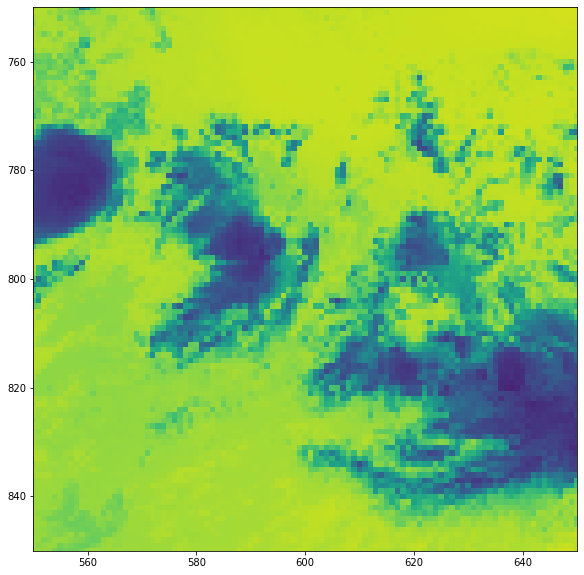

In [257]:
figure(figsize=(20,10))
imshow(grid, vmin=200, vmax=300)
xlim([550,650])
ylim([850,750])

(900.0, 700.0)

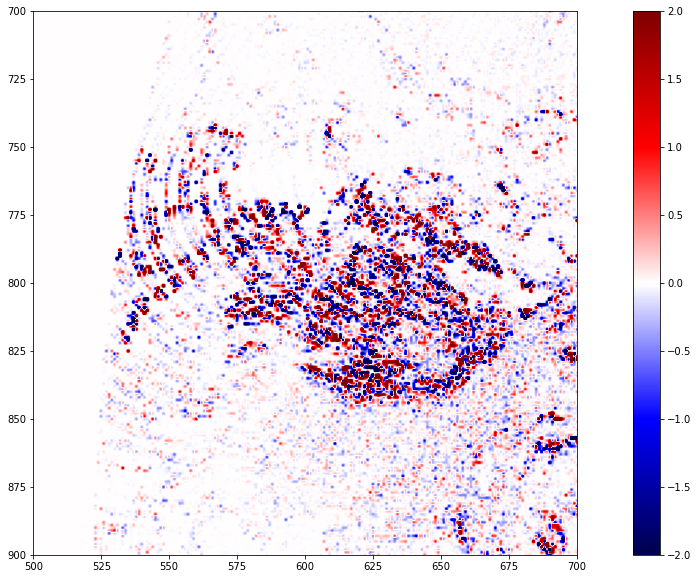

In [251]:
figure(figsize=(20,10))
imshow(grid1-grid, cmap='seismic', vmin=-2, vmax=2)
colorbar()
xlim([500,700])
ylim([900,700])

# Just illustrate the idea

In [14]:
# 10 degree grid
grid = make_index.get_grid(10)

In [16]:
%%time
grid_idx, sat_idx = make_index.get_index(area, grid, radius=150e3)

CPU times: user 23.7 s, sys: 39.6 s, total: 1min 3s
Wall time: 1min 5s


In [17]:
d = np.zeros(area.shape, dtype=np.uint32)
d.ravel()[sat_idx] = 1

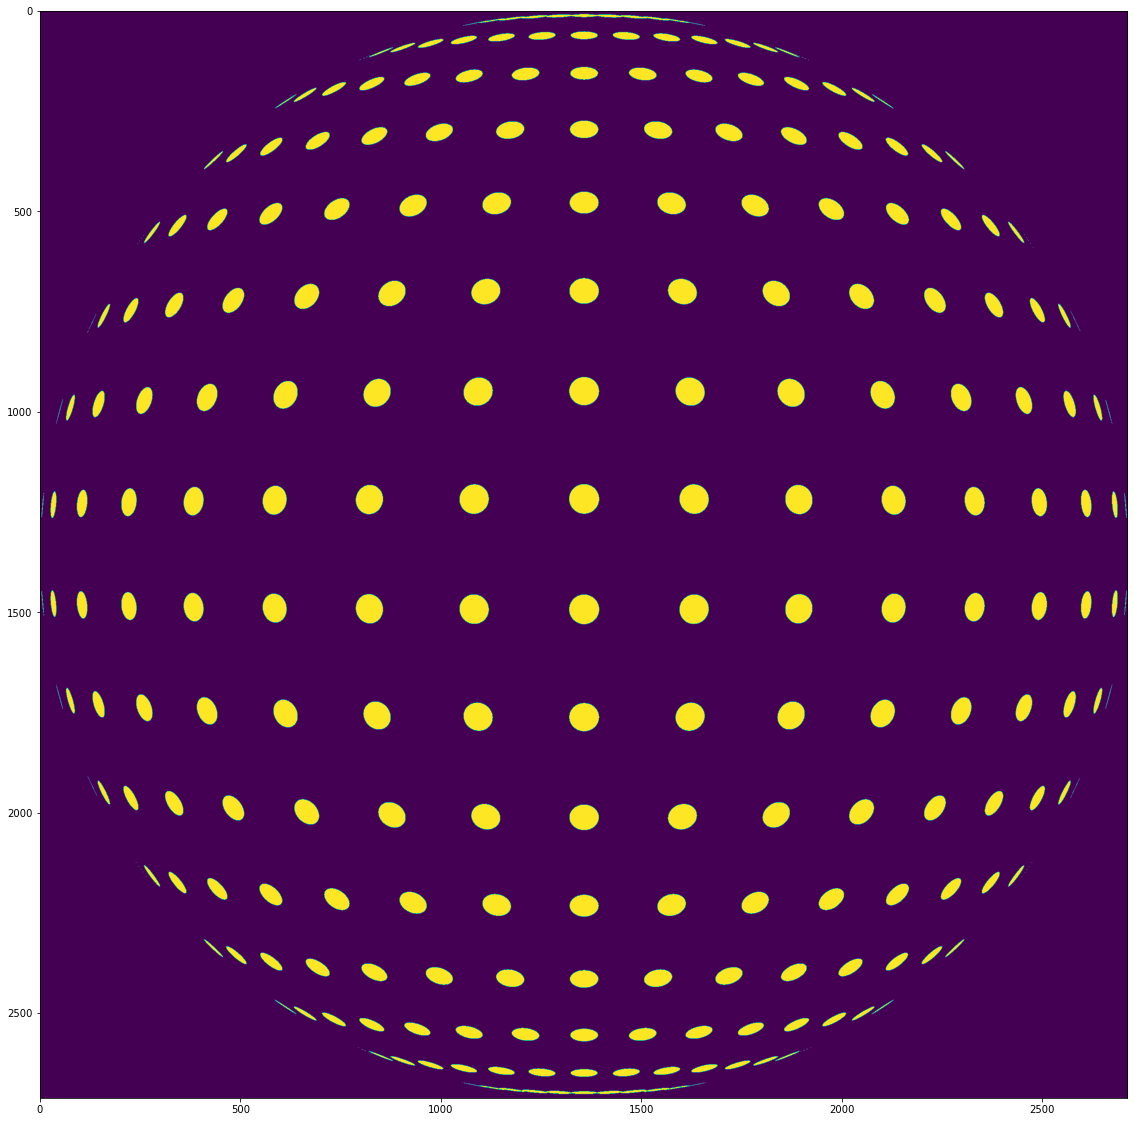

In [18]:
figure(figsize=(20,20))
imshow(d[::4,::4])

# Ok, run `make_index.py` elsewhere to make some indices

# Test

In [19]:
import numpy as np
import pandas as pd

In [20]:
f = 'l1b/g16/20200925T1800/01/OR_ABI-L1b-RadF-M6C01_G16_s20202691800201_e20202691809509_c20202691809570.nc'

In [21]:
dst = np.memmap('./index/g16/01/dst_index.dat', mode='r', dtype=np.uint64)
src = np.memmap('./index/g16/01/src_index.dat', mode='r', dtype=np.uint64)

In [22]:
%%time
a = pd.Series(c01.values.ravel()[src].astype(np.float32), index=dst)

CPU times: user 2.91 s, sys: 3.94 s, total: 6.86 s
Wall time: 4.38 s


In [23]:
%%time
a_mean = a.groupby(a.index).mean().dropna()

CPU times: user 8.25 s, sys: 5.44 s, total: 13.7 s
Wall time: 13.7 s


In [24]:
%%time
out = np.full((180*20,360*20), np.nan, dtype=np.float32)
out.ravel()[a_mean.index] = a_mean

CPU times: user 46.9 ms, sys: 48.1 ms, total: 95.1 ms
Wall time: 94.1 ms


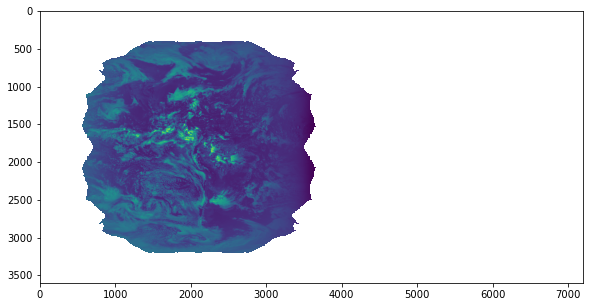

In [25]:
figure(figsize=(10,5))
imshow(out)